# Defining network and dataset

Let's first consider the same network and dataset used in the previous tutorial `nmnist-sinabs.ipynb`.

In [ ]:
#follow the same mental process we had in fixing problems

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sinabs.from_torch import from_model
from aermanager.datasets import SpikeTrainDataset

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
# define the network in the same way as the previous tutorial
ann = nn.Sequential(
    nn.Conv2d(2, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

# load the weights that we trained in the previous tutorial
ann.load_state_dict(torch.load("mnist_params300.pt"))

# turn into spiking model
sinabs_model = from_model(ann, input_shape=(2, 34, 34), add_spiking_output=False, synops=True)

WEIGHT_SCALE = 10.0
sinabs_model.spiking_model[0].weight.data = sinabs_model.spiking_model[0].weight * WEIGHT_SCALE

In [26]:
dataset_test_spiketrains = SpikeTrainDataset(
    "../aermanager/data/N-MNIST/Test/",
    transform=np.float32, # must turn frame data into floats
    target_transform=int, # string labels are turned into ints
    dt=1000, # time resolution of spikes fed to sinabs: 1000 microseconds
)

dataloader_test_spiketrains = DataLoader(
    dataset_test_spiketrains, shuffle=False,
    num_workers=4, batch_size=1)

# Comparing outputs of ANN and SNN


In [27]:
snn_outputs = []
ann_outputs = []
snn_correct = []
ann_correct = []


for data, target in dataloader_test_spiketrains:
    # frame data for the ann, and do forward pass
    frame = data.sum(1)
    ann_output = ann(frame).squeeze().detach().numpy()
    ann_outputs.append(ann_output)
    
    # do forward pass on SNN with spikes
    sinabs_model.reset_states()
    snn_output = sinabs_model(data.squeeze()).sum(0).detach().numpy()
    snn_outputs.append(snn_output)
    
    # compute accuracies
    ann_pred = ann_output.argmax()
    ann_correct.append(ann_pred == target.item())
    snn_pred = snn_output.argmax()
    snn_correct.append(snn_pred == target.item())
    
    if len(ann_outputs) >= 100:
        break

In [28]:
print("ANN accuracy:", sum(ann_correct)/len(ann_correct))
print("SNN accuracy:", sum(snn_correct)/len(snn_correct))

ANN accuracy: 0.97
SNN accuracy: 0.72


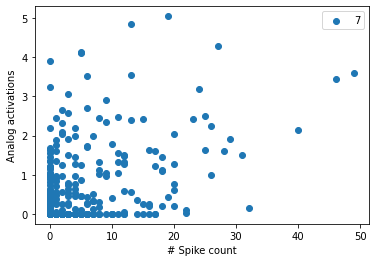

In [29]:
data = torch.tensor(dataset_test_spiketrains[0][0]).squeeze()

sinabs_model.reset_states()
sinabs_model.plot_comparison(data, ['7']);

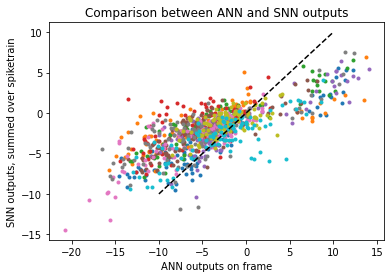

In [30]:
plt.plot(ann_outputs,
         np.array(snn_outputs) / WEIGHT_SCALE,
         ".")
plt.plot([-10, 10], [-10, 10], 'k--')

plt.title("Comparison between ANN and SNN outputs")
plt.xlabel("ANN outputs on frame")
plt.ylabel("SNN outputs, summed over spiketrain");

# Computing the number of synaptic operations

Whenever a neuron emits a spike, the chip communicates the spike to all the other neurons the first neuron is connected to, so that their membrane potentials can be updated accordingly. We call each of these a **synaptic operation**.

Due to how the chip is built, the power consumption is determined by the number of synaptic operations, not by the number of spikes: so, spikes from neurons that are connected to many downstream neurons will use more power than spikes from neurons with only a few outgoing connections. For our DYNAP-CNN chip, we estimate that each synaptic operation consumes around 10 picojoules ($10^{-11}$ J) of energy.

It's important that our network is as active as needed, but not more, since higher firing rates will use more power. In sinabs simulations, we can estimate the power consumption of our networks.

In [31]:
sinabs_model.get_synops()

In  Fanout_Prev     SynOps  N. timesteps  Time window (ms)  \
Layer                                                                   
1       300.0        500.0   150000.0            29              29.0   
4      7512.0        800.0  6009600.0            29              29.0   
7      3860.5       1152.0  4447296.0            29              29.0   
11      239.0        500.0   119500.0            29              29.0   
13      586.0         10.0     5860.0            29              29.0   

           SynOps/s  
Layer                
1      5.172414e+06  
4      2.072276e+08  
7      1.533550e+08  
11     4.120690e+06  
13     2.020690e+05

The table above summarises the activity of the network. The data refer to the *latest forward pass* (done in the cells above).

In particular, we are interested in the average rate of Synaptic Operations (synops) per second. We can also sum this value over all layers:

In [32]:
total_synops_per_second = sinabs_model.get_synops()["SynOps/s"].sum()

print(total_synops_per_second)

370077793.1034483


With the assumption of 1 synop consuming 10 pJ, then a network generating 1 synop per second will use 10 pW of power.
Using this and multiplying by 1000 we obtain the power consumption in milliwatts:

In [23]:
power_use_mW = total_synops_per_second * 1e-11 * 1000

print(power_use_mW)

3.7007779310344824


You can see we are under a mW of power use. Additionally, if no data are presented to the chip, no energy will be used at all.